# Learning Model Segment 3

## This version of the model looks at different types of supervised and deep learning models:
Possibilities include:
* Logistic Regression    
* Support Vector Machine
* Deep Learning Model

# new features:
* number of movies by director
* director success rate

In [15]:
# Import our dependencies
import numpy as np
import pandas as pd
import re
import csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [16]:
# Choose type of model to run:
model_type = 'NN'  # LR = logistic regression, NN = neural net, SV = support vector machine
# SVM is not running for some reason???? doesn't finish fit step?

def select_model(mtype):
    if mtype == 'LR':
        return 'U'
    elif mtype == 'NN':
        return 'S'
    elif mtype == 'SV':
        return 'S'

dataset = select_model(model_type)
print(model_type, dataset)

NN S


## Prepare Data

In [17]:
# input merged dataset and select the appropriate dataframe
df=pd.read_csv("Resources/merged_movies.csv", low_memory=False)

# drop genre variables from TMDB 
df.drop(['g_Action_TM', 'g_Adventure_TM', 'g_Animation_TM', 'g_Comedy_TM', 'g_Crime_TM', 
       'g_Documentary_TM', 'g_Drama_TM', 'g_Family_TM', 'g_Fantasy_TM', 'g_History_TM', 'g_Horror_TM',
       'g_Music_TM', 'g_Mystery_TM', 'g_News', 'g_Reality_TV', 'g_Romance_TM',
       'g_Sci_Fi', 'g_Sport', 'g_Thriller_TM','g_War_TM', 'g_Western_TM'], axis=1, inplace=True)

# drop columns with high percentage of missing values, and not needed
df.drop(["budget_IM", "budget_TM", "collection", "g_Foreign", "genre_name", "metascore", "orig_lang_cd", 
              "original_language", "popularity", "release_year_TM", "revenue", "runtime", "usa_gross_income", 
              "website", "worlwide_gross_income", "year"], axis=1, inplace=True)

# drop columns with too many unique values 
df.drop(["_merge", "country", "genre_list", "imdb_id", "language", "title"], axis=1, inplace=True)

# Drop any rows with missing values. Reassess whether the nulls can/should be recoded and kept.
df.dropna(axis=0, how="any", inplace=True)

# Choose dependent = predicted value:
# Options: avg_vote, reviews_from_critics, reviews_from_users, votes
# For this model pass, use avg_vote >= 7 as success
df["success"] = df["avg_vote"].map(lambda x: 1 if x>= 7.0 else 0)

# Drop unneeded dependent variables
df.drop(["avg_vote", "reviews_from_users", "reviews_from_critics", "votes"], axis=1, inplace=True)

# Categorical variables for encoding, if needed
cat_vars = ['g_Action_IM', 'g_Adult', 'g_Adventure_IM',
       'g_Animation_IM', 'g_Biography', 'g_Comedy_IM', 'g_Crime_IM',
       'g_Documentary_IM', 'g_Drama_IM', 'g_Family_IM', 'g_Fantasy_IM',
       'g_History_IM', 'g_Horror_IM', 'g_Music_IM', 'g_Musical',
       'g_Mystery_IM', 'g_Romance_IM', 'g_Thriller_IM', 'g_War_IM',
       'g_Western_IM']

print(df.columns)
print(df.index)
df["o_index"] = df.index
print(df["o_index"])

Index(['director_list', 'duration', 'g_Action_IM', 'g_Adult', 'g_Adventure_IM',
       'g_Animation_IM', 'g_Biography', 'g_Comedy_IM', 'g_Crime_IM',
       'g_Documentary_IM', 'g_Drama_IM', 'g_Family_IM', 'g_Fantasy_IM',
       'g_History_IM', 'g_Horror_IM', 'g_Music_IM', 'g_Musical',
       'g_Mystery_IM', 'g_Romance_IM', 'g_Thriller_IM', 'g_War_IM',
       'g_Western_IM', 'release_year_IM', 'success'],
      dtype='object')
Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     9,
               10,
            ...
            70510, 70511, 70512, 70513, 70514, 70516, 70517, 70520, 70523,
            70525],
           dtype='int64', length=56531)
0            0
1            1
2            2
3            3
4            4
         ...  
70516    70516
70517    70517
70520    70520
70523    70523
70525    70525
Name: o_index, Length: 56531, dtype: int64


In [18]:
print(df.loc[56531,:])

director_list       ['Sven J. Matten']
duration                         108.0
g_Action_IM                        0.0
g_Adult                            0.0
g_Adventure_IM                     0.0
g_Animation_IM                     0.0
g_Biography                        0.0
g_Comedy_IM                        0.0
g_Crime_IM                         0.0
g_Documentary_IM                   0.0
g_Drama_IM                         1.0
g_Family_IM                        0.0
g_Fantasy_IM                       0.0
g_History_IM                       0.0
g_Horror_IM                        0.0
g_Music_IM                         0.0
g_Musical                          0.0
g_Mystery_IM                       1.0
g_Romance_IM                       1.0
g_Thriller_IM                      0.0
g_War_IM                           0.0
g_Western_IM                       0.0
release_year_IM                 2015.0
success                              0
o_index                          56531
Name: 56531, dtype: objec

## Feature Extraction

Add additional featues extracted from directors input

In [19]:
# pd.set_option("max_rows", 20)

# extract info from director feature
# there are 52,754 movies with 1 director, and 3,777 movies with 2 directors
# there are 26,593 unique values of "director" (counting a pair of directors as a single value)

# hypothesis: more movies associated with a director indicates the director is considered more worthy of investment, 
# so considered by investors to be more successful?
# 58% of directors have 1 movie
# 17% of directors have 2 movies
#  7% of directors have 3 movies

# hypothesis: can calculate success ratio for each director and use as a feature in the model     


In [20]:
# Extract director names from director_list and put in two columns

# Issue = names with a single quote are inside double quotes
# in merged file looks like: Joe D'Amato""]"
# see how this is handled in database
# may need to modify the search based on the contents of the database

# There's probably a better way of dealing with lists in a df column, this is a rather slow

directors = df["director_list"].copy() # series of directors in a string, index=original
directors_list = directors.apply(eval) # convert series of strings to series of lists of directors, index=original
directors_cols = pd.DataFrame(index=df.index.copy())  # initialize df to hold directors names, index=original
print(len(directors))
print(len(directors_cols))
print(directors_list.isnull().sum())
print(directors_list.index)
print(directors_cols.index)

print(df.loc[56531,:])

# Create dataframe with director name as index, count of movies, count of successes, win_rate

# Output list of directors into 2 columns
# there must be a better way than this:

# To iterate over items in a pandas Series use series.iterrows() function which returns an iterator, a tuple
# yielding index and value for each item
# Series.iteritems(self)
# index – index of the series
# value – value is the contents of the series item
# it – it is the generator that iterates over the rows of DataFrame.

# index is class int
# value is class list
# value contains up to 2 directors
      
for index, row  in directors_list.iteritems():
    n = len(row)
    if n == 1:
        directors_cols.loc[index, 0] = row[0]
    else:
        directors_cols.loc[index, 0] = row[0]
        directors_cols.loc[index, 1] = row[1]
        
# Update df with directors in two columns. Drop the original string column
# print(f'\n df columns {df.columns}')
# print(f'\n directors cols {directors_cols.columns}')
# print(f'\n length {len(df)}')
directors_cols.rename(columns={0:'Director_1', 1:'Director_2'}, inplace=True)
print(f'\n length: {len(directors_cols)}')

df = pd.concat([df, directors_cols], axis=1, ignore_index=False, join="inner")
df.drop(["director_list"], axis=1, inplace=True) 
# print(f'\n length df  {len(df)}')
# print(f'\n df columns  {df.columns}')
# print(f'\n df:  {df.head()}')
print(df.loc[56531,:])

56531
56531
0
Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     9,
               10,
            ...
            70510, 70511, 70512, 70513, 70514, 70516, 70517, 70520, 70523,
            70525],
           dtype='int64', length=56531)
Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     9,
               10,
            ...
            70510, 70511, 70512, 70513, 70514, 70516, 70517, 70520, 70523,
            70525],
           dtype='int64', length=56531)
director_list       ['Sven J. Matten']
duration                         108.0
g_Action_IM                        0.0
g_Adult                            0.0
g_Adventure_IM                     0.0
g_Animation_IM                     0.0
g_Biography                        0.0
g_Comedy_IM                        0.0
g_Crime_IM                         0.0
g_Documentary_IM                   0.0
g_Drama_IM                         1.0
g_Family_IM                        0.0
g_Fantasy_IM                

In [21]:
# Calculate movies and success_rate by director - output df with director name as index, cols: movie_cnt, success_cnt, win_rate

# attach success indicator to directors_cols, by original index
success = df["success"].copy()         # series of success indicators, index=original
director_success = pd.concat([directors_cols, success], axis=1, ignore_index=False, join="inner")
print(director_success.columns)
directors1 = director_success[["Director_1", "success"]].copy()
directors2 = director_success[["Director_2", "success"]].copy()
directors2.dropna(inplace=True)

print(directors1.isnull().sum())
print(directors2.isnull().sum())

# get counts by director for both directors 
d1=directors1.groupby("Director_1", as_index=True)["success"].agg(['count', 'sum'])  # index is director name
d1.rename(columns={'count':'count1', 'sum':'sum1'})
d2=directors2.groupby("Director_2", as_index=True)["success"].agg(['count', 'sum'])  # index is director name
d2.rename(columns={'count':'count2', 'sum':'sum2'})
# print(f'\n directors1: count unique: {len(d1)}, index: {d1.index}, head: {d1.head()}')
# print(f'\n directors2: count_unique: {len(d2)}, index: {d2.index}, head: {d2.head()}')

# then concatenate and combine matching director names
# join counts by index (director name), this will creates nulls from d2
# calculate total movies count and success rate for each director
# output d1 has Director as index, and columns movie_cnt  success_cnt  win_rate

print(d1.isnull().sum())
print(d2.isnull().sum())

mask=d1.index.str.contains("Sven J. Matten", regex=False)
print(d1[mask])
mask2=d2.index.str.contains("Sven J. Matten", regex=False)
print(d2[mask2])

d1 = d1.join(d2, how="outer", rsuffix="2")
mask=d1.index.str.contains("Sven J. Matten", regex=False)
print(d1[mask])

d1 = d1.replace(np.nan,0)
d1["movie_cnt"] = d1["count"] + d1["count2"]
d1["success_cnt"] = d1["sum"] + d1["sum2"] 
d1["win_rate"] = d1["success_cnt"] / d1["movie_cnt"]
mask=d1.index.str.contains("Sven J. Matten", regex=False)
print(d1[mask])

d1.drop(["count", "sum", "count2", "sum2"], axis=1, inplace=True)
d1.index.name = "Director"
print(d1.isnull().sum())
print(f'\n {d1.index}')
print(f'\n {d1.columns}')
print(f'\n {len(d1)}')

Index(['Director_1', 'Director_2', 'success'], dtype='object')
Director_1    0
success       0
dtype: int64
Director_2    0
success       0
dtype: int64
count    0
sum      0
dtype: int64
count    0
sum      0
dtype: int64
                count  sum
Director_1                
Sven J. Matten      2    0
Empty DataFrame
Columns: [count, sum]
Index: []
                count  sum  count2  sum2
Sven J. Matten    2.0  0.0     NaN   NaN
                count  sum  count2  sum2  movie_cnt  success_cnt  win_rate
Sven J. Matten    2.0  0.0     0.0   0.0        2.0          0.0       0.0
movie_cnt      0
success_cnt    0
win_rate       0
dtype: int64

 Index([' A. Blaine Miller', ' A.L. Vijay', ' A.S. Ravindra Babu', ' Aaron Lim',
       ' Aaron Moorhead', ' Aaron Nee', ' Aaron Osborne', ' Aaron Russo',
       ' Aaron Seltzer', ' Aaron T. Wells',
       ...
       'Özcan Deniz', 'Özer Kiziltan', 'Özgür Bakar', 'Özgür Sevimli',
       'Özgür Yildirim', 'Özhan Eren', 'Øystein Karlsen', 'Øystein Ste

In [22]:
# Calculate director ratings by movie
# attach director ratings to each movie by director name, note some movies have 2 directors, so separate joins required

# there's got to be a better way to do this
# Get only Director_1 and Director_2 from df, then merge each column with d1 on Director
# want result Director_1, movie_cnt, win_rate, Director_2, movie_cnt_2, win_rate_2, index is still from the original df

# note: There will be duplicate values of Director_1 and Director_2 in df_subset, but d1 has only unique values for Director
# The index of d1 is Director
# The index of df_subset is the original index from df
# use join since it can handle non-unique keys but need to set the index of df_subset to the key before joining on index
# carry along o_index - the original index since that seems to get lost when resetting in order to join

d1.sort_values(by="Director")
print(d1.index)
print(d1.columns)
df_subset = df[["o_index", "Director_1", "Director_2"]].copy()
df_subset.sort_values(by="Director_1")
df_subset = df_subset.set_index("Director_1").join(d1, how="left")

print(df_subset.isnull().sum())
print(df_subset.columns)
print(len(df_subset))

# get only those with Director_2 not missing
df_subset_A = df_subset.dropna()
print(df_subset_A.columns)
print(df_subset_A.index)
len(df_subset_A)

df_subset_A.sort_values(by="Director_2")
df_subset_A = df_subset_A.set_index("Director_2").join(d1, how="left", rsuffix="_2")
print(df_subset_A.isnull().sum())
print(df_subset_A.columns)
print(len(df_subset_A))
df_subset_A.drop(['movie_cnt', 'success_cnt', 'win_rate'], axis=1, inplace=True)
print(df_subset_A.columns)

df_subset.drop("Director_2", axis=1, inplace=True)
print(df_subset_A.columns)

df_subset = df_subset.set_index("o_index").join(df_subset_A.set_index('o_index'), how="left")
print(df_subset.columns)
print(df_subset.index)
print(df_subset.isnull().sum())
df_subset.fillna(0, inplace=True)
print(df_subset.isnull().sum())

# print(df_subset.isnull().sum())
# print(len(df_subset))

# df_subset = df_subset.reset_index()

# print(df_subset.index.name)
# print(df_subset.index)
# print(df_subset.columns)

# df_subset['success_cnt_2'].fillna(0, inplace=True)
# df_subset['win_rate_2'].fillna(0, inplace=True)
  

# df_subset = df_subset.merge(d1, how="left", left_on = "Director_1", right_on = "Director")
# print(df_subset.isnull().sum())
# df_subset.sort_values(by="Director_2")
# df_subset = df_subset.merge(d1, how="left", left_on = "Director_2", right_on = "Director", suffixes=(None, "_2"))
# print(df_subset.isnull().sum())
# # print(df_subset.columns)
# print(len(df_subset))
# print(df_subset.isnull().sum())
# print(df_subset.tail())

Index([' A. Blaine Miller', ' A.L. Vijay', ' A.S. Ravindra Babu', ' Aaron Lim',
       ' Aaron Moorhead', ' Aaron Nee', ' Aaron Osborne', ' Aaron Russo',
       ' Aaron Seltzer', ' Aaron T. Wells',
       ...
       'Özcan Deniz', 'Özer Kiziltan', 'Özgür Bakar', 'Özgür Sevimli',
       'Özgür Yildirim', 'Özhan Eren', 'Øystein Karlsen', 'Øystein Stene',
       'Ümit Cin Güven', 'Ümit Ünal'],
      dtype='object', name='Director', length=28216)
Index(['movie_cnt', 'success_cnt', 'win_rate'], dtype='object')
o_index            0
Director_2     52754
movie_cnt          0
success_cnt        0
win_rate           0
dtype: int64
Index(['o_index', 'Director_2', 'movie_cnt', 'success_cnt', 'win_rate'], dtype='object')
56531
Index(['o_index', 'Director_2', 'movie_cnt', 'success_cnt', 'win_rate'], dtype='object')
Index(['A. Mahadev', 'A.L. Vijay', 'A.L. Vijay', 'A.L. Vijay', 'A.L. Vijay',
       'A.L. Vijay', 'A.L. Vijay', 'A.L. Vijay', 'Aamir Khan', 'Aaron Blaise',
       ...
       'Ángel de la 

In [23]:
# Calculate combined director rating for each movie as
# the max movie_cnt and max win_rate across Director_1, Director_2 for each movie.
# should have the same number of movies: 56531

# prepare data for calculations
# df_subset['movie_cnt_2'].fillna(0, inplace=True)
# df_subset['success_cnt_2'].fillna(0, inplace=True)
# df_subset['win_rate_2'].fillna(0, inplace=True)
# print(df_subset.columns)

print(df_subset.isnull().sum())
print(df_subset.columns)
print(df_subset.index)

# For each movie determine the highest director rating
# Where there are 2 directors, take the max win_rate and the max movies_cnt for the movie score   
# columns are in this order:  0:movie_cnt  1:success_cnt 2:win_rate  3:movie_cnt_2  
# 4:success_cnt_2  5:win_rate_2  
# columns in director_ratings: 0:director_score_cnt 1:director_score_rate

directors_ratings = pd.DataFrame(index=df.index.copy())  # initialize df to hold directors ratings, index=original
print(directors_ratings.shape) 

for index, row  in df_subset.iterrows():
    if row[3] is not None:
        if row[3] > row[0]:
            directors_ratings.loc[index, 0] = row[3]
        else:
            directors_ratings.loc[index, 0] = row[0]
        if row[5] > row[2]:
            directors_ratings.loc[index, 1] = row[5]
        else:
            directors_ratings.loc[index, 1] = row[2]
    else:
        directors_ratings.loc[index, 0] = row[0]
        directors_ratings.loc[index, 1] = row[2]

# print(directors_ratings.head(50))
# print(directors_ratings.isnull().sum())
# print(directors_ratings["movie_cnt_2"].value_counts(dropna=False))
# # print(df_subset.columns)
directors_ratings.columns = ("director_score_cnt", "director_score_rate")
# # print(directors_ratings.head(20))
# # add director ratings to df on original index
df = pd.concat([df, directors_ratings], axis=1, ignore_index=False, join="inner")
# print(len(df))
print(df.columns)
print(len(df))

movie_cnt        0
success_cnt      0
win_rate         0
movie_cnt_2      0
success_cnt_2    0
win_rate_2       0
dtype: int64
Index(['movie_cnt', 'success_cnt', 'win_rate', 'movie_cnt_2', 'success_cnt_2',
       'win_rate_2'],
      dtype='object')
Int64Index([28193, 28509, 14657, 27623, 19582, 59386, 23190, 31451, 33833,
            45102,
            ...
            64539, 39562, 59107, 50039, 47449, 27685, 27581, 44571, 49399,
            63538],
           dtype='int64', name='o_index', length=56531)
(56531, 0)
Index(['duration', 'g_Action_IM', 'g_Adult', 'g_Adventure_IM',
       'g_Animation_IM', 'g_Biography', 'g_Comedy_IM', 'g_Crime_IM',
       'g_Documentary_IM', 'g_Drama_IM', 'g_Family_IM', 'g_Fantasy_IM',
       'g_History_IM', 'g_Horror_IM', 'g_Music_IM', 'g_Musical',
       'g_Mystery_IM', 'g_Romance_IM', 'g_Thriller_IM', 'g_War_IM',
       'g_Western_IM', 'release_year_IM', 'success', 'o_index', 'Director_1',
       'Director_2', 'director_score_cnt', 'director_score_rate

In [24]:
print(df.head())

   duration  g_Action_IM  g_Adult  g_Adventure_IM  g_Animation_IM  \
0     106.0          0.0      0.0             0.0             0.0   
1      90.0          0.0      0.0             0.0             0.0   
2      45.0          0.0      0.0             0.0             0.0   
3     160.0          0.0      0.0             0.0             0.0   
4      76.0          0.0      0.0             0.0             0.0   

   g_Biography  g_Comedy_IM  g_Crime_IM  g_Documentary_IM  g_Drama_IM  ...  \
0          0.0          0.0         0.0               0.0         1.0  ...   
1          0.0          0.0         0.0               0.0         1.0  ...   
2          0.0          0.0         0.0               0.0         1.0  ...   
3          1.0          0.0         0.0               0.0         1.0  ...   
4          0.0          1.0         0.0               0.0         1.0  ...   

   g_Thriller_IM  g_War_IM  g_Western_IM  release_year_IM  success  o_index  \
0            0.0       0.0           

In [25]:
# # print(directors_ratings.head(50))
# # print(directors_ratings.value_counts())

# print(directors_ratings.columns)
# print(directors_ratings[0])
# mask = directors_ratings[0].isnull()
# print(directors_ratings[mask == True])

# # print(directors_ratings["movie_cnt_2"].value_counts(dropna=False))
# # # print(df_subset.columns)
# # directors_ratings.columns = ("director_score_cnt", "director_score_rate")
# # # print(directors_ratings.head(20))

# # # add director ratings to df on original index
# # df = pd.concat([df, directors_ratings], axis=1, ignore_index=False, join="inner")
# # print(len(df))

In [26]:
print(df.loc[56531,:])

duration                        108.0
g_Action_IM                       0.0
g_Adult                           0.0
g_Adventure_IM                    0.0
g_Animation_IM                    0.0
g_Biography                       0.0
g_Comedy_IM                       0.0
g_Crime_IM                        0.0
g_Documentary_IM                  0.0
g_Drama_IM                        1.0
g_Family_IM                       0.0
g_Fantasy_IM                      0.0
g_History_IM                      0.0
g_Horror_IM                       0.0
g_Music_IM                        0.0
g_Musical                         0.0
g_Mystery_IM                      1.0
g_Romance_IM                      1.0
g_Thriller_IM                     0.0
g_War_IM                          0.0
g_Western_IM                      0.0
release_year_IM                2015.0
success                             0
o_index                         56531
Director_1             Sven J. Matten
Director_2                        NaN
director_sco

In [27]:
print(df.isnull().sum())

duration                   0
g_Action_IM                0
g_Adult                    0
g_Adventure_IM             0
g_Animation_IM             0
g_Biography                0
g_Comedy_IM                0
g_Crime_IM                 0
g_Documentary_IM           0
g_Drama_IM                 0
g_Family_IM                0
g_Fantasy_IM               0
g_History_IM               0
g_Horror_IM                0
g_Music_IM                 0
g_Musical                  0
g_Mystery_IM               0
g_Romance_IM               0
g_Thriller_IM              0
g_War_IM                   0
g_Western_IM               0
release_year_IM            0
success                    0
o_index                    0
Director_1                 0
Director_2             52754
director_score_cnt         0
director_score_rate        0
dtype: int64


In [28]:
# drop unneeded columns
df.drop(["Director_1", "Director_2"], axis=1, inplace=True)

In [29]:
df.drop(["o_index"], axis=1, inplace=True)

# Preprocess data

In [30]:
if dataset == 'S':  # create encoded and scaled dataset
    # Encode categorical variables
    # Create a OneHotEncoder instance
    enc = OneHotEncoder(sparse=False)
    # Fit and transform the OneHotEncoder using the categorical variable list
    encode_df =pd.DataFrame(enc.fit_transform(df[cat_vars]))
    # Add the encoded variable names to the DataFrame
    encode_df.columns =enc.get_feature_names(cat_vars)
    # Merge one-hot encoded features and drop the originals
    df =df.merge(encode_df,left_index=True,right_index=True)
    df.drop(cat_vars,axis=1, inplace=True)

## Create Sample Datasets

In [31]:
# Split our preprocessed data into our features and target arrays
y =df["success"].values
X =df.drop(["success"],1).values

# Split the preprocessed data into a training and testing dataset
X_train,X_test,y_train,y_test =train_test_split(X,y,stratify=y,random_state=78)

## Scale data if needed

In [32]:
if dataset == 'S':  # create encoded and scaled dataset
    X_scaler = StandardScaler()
    # Fit the scaler
    X_scaler.fit(X_train)
    # Scale the data
    X_train =X_scaler.transform(X_train)
    X_test =X_scaler.transform(X_test)

## Define the learning model

In [33]:
if model_type == "LR":
    log_classifier =LogisticRegression(solver="lbfgs",max_iter=200)
    print(type(X_train))
#     print(X_train.describe)
    print(type(y_train))
#     print(y_train.describe)
    
    # Train the model
    log_classifier.fit(X_train,y_train)
    


    # Evaluate the model
    y_pred =log_classifier.predict(X_test)
    print(f" Logistic regression model accuracy: {accuracy_score(y_test,y_pred):.3f}")

In [34]:
if model_type == "SV":
    # Create the SVM model
    svm =SVC(kernel='linear')
    print('created svm')
    # Train the model
    svm.fit(X_train,y_train)
    print('fit svm')
    # Evaluate the model
    y_pred =svm.predict(X_test)
    print('predicted svm')
    print(f" SVM model accuracy: {accuracy_score(y_test,y_pred):.3f}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 225       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 18        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 247
Trainable params: 247
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
753/753 [==============================] - 1s 1ms/step - loss: 0.3442 - accuracy: 0.8524 - val_loss: 0.2514 - val_accuracy: 0.8953
Epoch 2/30
753/753 [==============================] - 1s 969us/step - loss: 0.2399 - accuracy: 0.8987 - val_loss: 0.2368 - val_accuracy: 0.8981
Epoch 3/30
753/753 [==============================] - 1s 736us/step - loss: 0.2297 - accuracy: 0.8992 

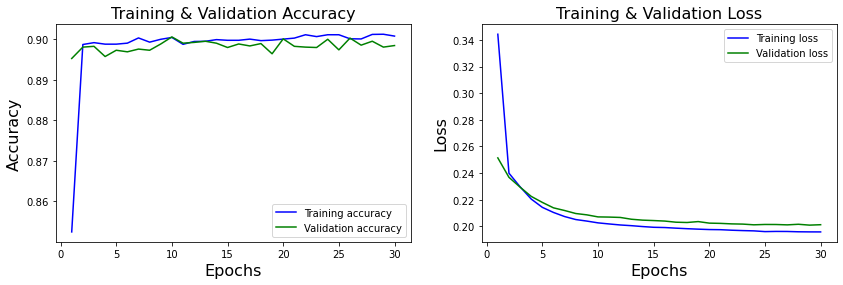

In [35]:
if model_type == "NN":
    # Create the Keras Sequential model
    # use validation_split argument to set the proportion of the dataset to reserve for validation
    number_input_features =len(X_train[0])
    hidden_nodes_layer1 = 5
    hidden_nodes_layer2 = 3
    nn =tf.keras.models.Sequential()
    # layers
    nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1,activation="tanh",input_dim=number_input_features))
    nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2,activation="tanh"))

    # Add the output layer that uses a probability activation function
    nn.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
    
    # Check the structure of the Sequential model
    nn.summary()

    # Compile the Sequential model together and customize metrics
    nn.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

    # Fit the model to the training data
    fit_model =nn.fit(X_train,y_train,validation_split=.3, epochs=30)

    # Evaluate the model using the test data
    model_loss,model_accuracy =nn.evaluate(X_test,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
    
    # Create learning curve for both train and validation datasets to evaluate under- and over-fitting

    history_dict=fit_model.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']

    epochs = range(1, len(loss_values) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    #
    # Plot the model accuracy vs Epochs
    #
    ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
    ax[0].plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    ax[0].set_title('Training & Validation Accuracy', fontsize=16)
    ax[0].set_xlabel('Epochs', fontsize=16)
    ax[0].set_ylabel('Accuracy', fontsize=16)
    ax[0].legend()
    #
    # Plot the loss vs Epochs
    #
    ax[1].plot(epochs, loss_values, 'b', label='Training loss')
    ax[1].plot(epochs, val_loss_values, 'g', label='Validation loss')
    ax[1].set_title('Training & Validation Loss', fontsize=16)
    ax[1].set_xlabel('Epochs', fontsize=16)
    ax[1].set_ylabel('Loss', fontsize=16)
    ax[1].legend()

    plt.show()